In [2]:
import os
import cv2
import math
import keras
import seaborn
import time
import warnings
import sklearn

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from skimage.transform import resize
from sklearn.model_selection import train_test_split, StratifiedKFold

from keras.models import Model
from keras import layers, models
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [4]:
K.set_image_data_format('channels_last')

create_image_rows = 420
create_image_cols = 580
smooth = 1.0

In [5]:
mask_t = np.load('./imgs_mask_train.npy')
image_t = np.load('./imgs_train.npy')

warnings.filterwarnings(action='ignore')

In [6]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [7]:
def SRAD(i, niter, lamda, rect):
    # make image a double and normalize on[0, 1]
    i = i.astype('float32')
    mx = np.max(i[:])
    mn = np.min(i[:])
    i = (i-mn)/(mx-mn)

    # make image a double and normalize on[0, 1]
    [M, N] = np.shape(i)

    # image indices (using boudary conditions)
    iN = np.hstack((np.array(0),np.arange(0,M-1)))
    iS = np.hstack((np.arange(1,M-1),np.array(M-1),np.array(M-1)))
    jW = np.hstack((np.array(0),np.arange(0,N-1)))
    jE = np.hstack((np.arange(1,N-1),np.array(N-1),np.array(N-1)))
    
    # log uncompress (also eliminates zero value pixels)
    i = np.exp(i)

    # main algorithm
    for liter in np.arange(1,niter+1):

         # speckle scale function
        Iuniform = i[rect[0]:rect[1],rect[2]:rect[3]]
        q0_squared = np.var(Iuniform[:]) / ((np.mean(Iuniform[:]))**2)

        # difference
        dN = i[iN, :] - i
        dS = i[iS, :] - i
        dW = i[:, jW] - i
        dE = i[:, jE] - i

        # normalized discrete gradient magnitude squared (equ 52,53)
        G2 = (pow(dN,2) + pow(dS, 2) + pow(dW, 2) + pow(dE, 2)) / (pow(i, 2))

        # normalized discrete laplacian (equ 54)
        L = (dN + dS + dW + dE)/i

        # ICOV (equ 31/35)
        num = (0.5*G2) - ((1/16)*(pow(L, 2)))
        den = pow((1 + ((1/4)*L)), 2)
        q_squared = num / (den + np.finfo(float).eps)

        # diffusion coefficent (equ 33)
        den = (q_squared - q0_squared) / (q0_squared * (1 + q0_squared) +np.finfo(float).eps)
        c = 1 / (1 + den)

        # saturate diffusion coefficent
        c[c < 0] = 0
        c[c > 1] = 1

        # divergence (equ 58)
        cS = c[iS, :]
        cE = c[:,jE]
        D = (c*dN) + (cS*dS) + (c*dW) + (cE*dE)
        
        # update
        i = i + (lamda/4)*D; 
        
    J = np.log(i)
    J=np.round(J*255)
    J=J.astype('uint8')
    return J

In [8]:
train_image_rows = 96
train_image_cols = 96
winodw_size = 5
import scipy 

def preprocess_msk(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        imgs_p[i] = resize(imgs[i].astype('float32'), (train_image_rows,
                                                       train_image_cols), mode='reflect', preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


def preprocess_img(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        #img = lee_filter(imgs[i],9)
        #img = SRAD(imgs[i],5, 1, [0, 420, 0, 580])
        #img = scipy.signal.wiener(imgs[i].astype('float32'), mysize=5)
        #img = cv2.blur(imgs[i].astype('float32').astype('float32'),(winodw_size,winodw_size))
        #img = imgs[i]
        imgs_p[i] = resize(img.astype('float32'), (train_image_rows,
                                                       train_image_cols), mode='reflect', preserve_range=True)
        mean = np.mean(imgs_p[i])
        std = np.std(imgs_p[i])

        imgs_p[i] -= mean
        imgs_p[i] /= std
        
    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [9]:
image_c = preprocess_img(image_t)
mask_c = preprocess_msk(mask_t)

mask_c /= 255.  # scale masks to [0, 1]

NameError: name 'img' is not defined

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection+ K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def recall(y_true, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred_f, 0, 1))
    # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_true_f, 0, 1))

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = (count_true_positive+ K.epsilon()) / \
        (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_true, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred_f, 0, 1))
    # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_true_f, 0, 1))

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn)

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = (count_true_positive+ K.epsilon()) / \
        (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def mean_iou(y_true, y_pred, smooth=1):
    y_pred_N = K.round(K.clip(y_pred, 0, 1))
    y_true_N = K.round(K.clip(y_true, 0, 1))
    intersection = K.sum(K.abs(y_pred_N * y_true_N), axis=-1)
    union = K.sum(y_true_N, axis=-1) + K.sum(y_pred_N, axis=-1)
    iou = (intersection+ K.epsilon()) / (union+ K.epsilon())
    return iou

In [ ]:
def get_CAE_Unet():
    inputs = layers.Input((train_image_rows, train_image_cols, 1))
    conv1 = layers.Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='lecun_normal')(inputs)
    conv1 = layers.Dropout(0.1)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.Dropout(0.1)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = layers.Dropout(0.1)(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = layers.Dropout(0.1)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = layers.Dropout(0.1)(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(
        2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='he_normal')(up6)
    conv6 = layers.Dropout(0.1)(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(
        2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='he_normal')(up7)
    conv7 = layers.Dropout(0.1)(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(
        2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='he_normal')(up8)
    conv8 = layers.Dropout(0.1)(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='he_normal')(up9)
    conv9 = layers.Dropout(0.1)(conv9)
    
    conv10 = layers.Conv2D(
        1, (1, 1), activation='elu', padding='same')(conv9)
    
    conv11 = layers.Conv2D(32, (3, 3),activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='lecun_normal')(conv10)
    pool11 = layers.MaxPooling2D(pool_size=(2, 2))(conv11)

    conv12 = layers.Conv2D(64, (3, 3),activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='lecun_normal')(pool11)
    pool12 = layers.MaxPooling2D(pool_size=(2, 2))(conv12)

    conv13 = layers.Conv2D(128, (3, 3), activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='lecun_normal')(pool12)
    pool13 = layers.MaxPooling2D(pool_size=(2, 2))(conv13)

    conv14 = layers.Conv2D(256, (3, 3),activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='lecun_normal')(pool13)
    pool14 = layers.MaxPooling2D(pool_size=(2, 2))(conv14)

    conv15 = layers.Conv2D(512, (3, 3),activation='elu', kernel_regularizer=regularizers.l2(
        0.002), padding='same', kernel_initializer='lecun_normal')(pool14)

    up16 = layers.Conv2DTranspose(256, (2, 2), strides=(
        2, 2), padding='same')(conv15)
    
    
    up17 = layers.Conv2DTranspose(128, (2, 2), strides=(
        2, 2), padding='same')(up16)

    up18 = layers.Conv2DTranspose(64, (2, 2), strides=(
        2, 2), padding='same')(up17)

    up19 = layers.Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(up18)
    
    conv20 = layers.Conv2D(
        1, (1, 1), activation='sigmoid', padding='same')(up19)

    model = Model(inputs=[inputs], outputs=[conv20])
    model.compile(optimizer=keras.optimizers.Adam(lr=.0001), loss=dice_coef_loss, metrics=[
                  dice_coef, recall, precision, mean_iou])
    # print((model.summary()))

    return model

In [ ]:
CAE_Unet = get_CAE_Unet()

In [ ]:
import h5py

image_t =h5py.File('./imgs_train_lemva_5_10.h5', 'r')
image_t =image_t.get('image')
image_t= np.array(image_t)
image_t=np.transpose(image_t)

In [ ]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(
        name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-5, mode='min')
    early_stopping = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

    tb_hist = TensorBoard(log_dir='./logs',
                          histogram_freq=0, write_grads=True, write_images=True)
    return [mcp_save, reduce_lr_loss, early_stopping, tb_hist]

In [ ]:
image_c =np.load('./image_FROST_3.npy')

In [ ]:
winodw_size = 7
def preprocess_img(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.float32)
    for i in tqdm_notebook(range(imgs.shape[0])):
        #img = lee_filter(imgs[i],5)
        #img = SRAD(imgs[i],20, 1, [0, 420, 0, 580])
        #img = scipy.signal.wiener(imgs[i].astype('float32'), mysize=9)
        #img = cv2.blur(imgs[i].astype('float32').astype('float32'),(winodw_size,winodw_size))
        img = imgs[i]
        imgs_p[i] = resize(img.astype('float32'), (train_image_rows,
                                                       train_image_cols), mode='reflect', preserve_range=True)
        mean = np.mean(imgs_p[i])
        std = np.std(imgs_p[i])

        imgs_p[i] -= mean
        imgs_p[i] /= std
        
    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

#image_c = preprocess_img(image_t)

In [ ]:
folds = list(StratifiedKFold(n_splits=5, shuffle=True,
                             random_state=42).split(image_c[:, 0, 0], mask_c[:, 0, 0]))

In [16]:
path

'./Result/U_Net_CAE/Frost/2-3/새 폴더'

In [ ]:
import h5py
for ind_fil in ['']:
    #image_t =h5py.File('./imgs_train_Frost_'+str(ind_fil) +'.h5', 'r')
    #image_t =image_t.get('image')
    #image_t= np.array(image_t)
    #image_t=np.transpose(image_t)
    image_c = preprocess_img(image_t)
    folds = list(StratifiedKFold(n_splits=5, shuffle=True,
                             random_state=42).split(image_c[:, 0, 0], mask_c[:, 0, 0]))
    for ind in ['']:
        path = "./Result/U_Net_CAE/"+str(ind_fil) +ind
        winodw_size = 0
        CAE_Unet = get_CAE_Unet()

        for j, (train_idx, val_idx) in enumerate(folds):
            now = time.localtime()
            s = "%02d-%02d-%02d_%02d;%02d" % (now.tm_year-2000,
                                          now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min)
            print('\nFold ', j)
            image_train_cv = image_c[train_idx]
            mask_train_cv = mask_c[train_idx]
            image_valid_cv = image_c[val_idx]
            mask_valid_cv = mask_c[val_idx]

            name_weights = path+"/final_model_fold_" + \
                str(j) + str(winodw_size) + "_weights.h5"
            callbackk = get_callbacks(name_weights=name_weights, patience_lr=10)

            history = CAE_Unet.fit(image_train_cv, mask_train_cv, epochs=50, verbose=2, shuffle=True, validation_data=(
            image_valid_cv, mask_valid_cv), batch_size=32, callbacks=callbackk)

            if history.history['dice_coef'][-1] < 0.05:
                break
            df = pd.DataFrame({"val_loss": history.history['val_loss'],
                           "val_dice_coef": history.history['val_dice_coef'],
                           "val_precision": history.history['val_precision'],
                           "val_recall": history.history['val_recall']})
            df = df*100
            df.to_csv(
                path+'/history_{:2.3}_{}.csv'.format(history.history['val_dice_coef'][-1], s))
            print(CAE_Unet.evaluate(image_valid_cv, mask_valid_cv, verbose=2))

        mask_predict = CAE_Unet.predict(image_valid_cv, verbose=2)

        mask_r = mask_predict.reshape(1127, 96, 96)
        mask_test_u = mask_valid_cv.reshape(1127, 96, 96)
        image_test_u = image_valid_cv.reshape(1127, 96, 96)

        img_test_o = (mask_r*2)+image_test_u
        img_predict_o = image_test_u+(mask_test_u*2)

        np.random.seed(0)
        for num in np.random.choice(1127, 10, replace=False):
            plt.figure(figsize=(10, 10))
            plt.subplot(2, 2, 1)
            plt.imshow(cv2.resize(mask_test_u[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Original_lable_'+str(num))

            plt.subplot(2, 2, 2)
            plt.imshow(cv2.resize(mask_r[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Predict_lable_'+str(num))

            plt.subplot(2, 2, 3)
            plt.imshow(cv2.resize(img_test_o[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Original_US_'+str(num))

            plt.subplot(2, 2, 4)
            plt.imshow(cv2.resize(img_predict_o[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Predict_US_'+str(num))
            plt.savefig(path+'/Result'+str(num)+'.png')
            plt.show()

In [16]:
winodw_size = 0

CAE_Unet = get_CAE_Unet()

for j, (train_idx, val_idx) in enumerate(folds):
    now = time.localtime()
    s = "%02d-%02d-%02d_%02d;%02d" % (now.tm_year-2000,
                                      now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min)
    path = "./Result/U_Net_CAE/Lee/5/새 폴더"
    print('\nFold ', j)
    image_train_cv = image_c[train_idx]
    mask_train_cv = mask_c[train_idx]
    image_valid_cv = image_c[val_idx]
    mask_valid_cv = mask_c[val_idx]

    name_weights = path + "/final_model_fold_" + \
        str(j) + str(winodw_size) + "_weights.h5"
    callbackk = get_callbacks(name_weights=name_weights, patience_lr=10)

    history = CAE_Unet.fit(image_train_cv, mask_train_cv, epochs=50, verbose=2, shuffle=True, validation_data=(
        image_valid_cv, mask_valid_cv), batch_size=32, callbacks=callbackk)

    if history.history['dice_coef'][-1] < 0.05:
        break
    df = pd.DataFrame({"val_loss": history.history['val_loss'],
                       "val_dice_coef": history.history['val_dice_coef'],
                       "val_precision": history.history['val_precision'],
                       "val_recall": history.history['val_recall']})
    df = df*100

    df.to_csv(
        path+'/history_{:2.3}_{}.csv'.format(history.history['val_dice_coef'][-1], s))
    print(CAE_Unet.evaluate(image_valid_cv, mask_valid_cv, verbose=2))


Fold  0


W1023 05:20:53.624119 16872 deprecation_wrapper.py:119] From d:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 4508 samples, validate on 1127 samples


W1023 05:20:53.633122 16872 deprecation_wrapper.py:119] From d:\program files\python37\lib\site-packages\keras\callbacks\tensorboard_v1.py:200: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1023 05:20:53.634123 16872 deprecation_wrapper.py:119] From d:\program files\python37\lib\site-packages\keras\callbacks\tensorboard_v1.py:203: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/50
 - 23s - loss: 6.4666 - dice_coef: 0.1595 - recall: 0.6074 - precision: 0.1321 - mean_iou: 0.6648 - val_loss: 4.8819 - val_dice_coef: 0.3168 - val_recall: 0.3136 - val_precision: 0.3572 - val_mean_iou: 0.9844


W1023 05:21:21.782499 16872 deprecation_wrapper.py:119] From d:\program files\python37\lib\site-packages\keras\callbacks\tensorboard_v1.py:343: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



Epoch 2/50
 - 12s - loss: 4.0979 - dice_coef: 0.4591 - recall: 0.5284 - precision: 0.4403 - mean_iou: 0.9825 - val_loss: 3.6128 - val_dice_coef: 0.4285 - val_recall: 0.4193 - val_precision: 0.5112 - val_mean_iou: 0.9860
Epoch 3/50
 - 12s - loss: 3.1698 - dice_coef: 0.5269 - recall: 0.5827 - precision: 0.5098 - mean_iou: 0.9844 - val_loss: 2.9228 - val_dice_coef: 0.4718 - val_recall: 0.4950 - val_precision: 0.5089 - val_mean_iou: 0.9857
Epoch 4/50
 - 13s - loss: 2.6061 - dice_coef: 0.5640 - recall: 0.6013 - precision: 0.5578 - mean_iou: 0.9857 - val_loss: 2.4763 - val_dice_coef: 0.4929 - val_recall: 0.5495 - val_precision: 0.4910 - val_mean_iou: 0.9850
Epoch 5/50
 - 13s - loss: 2.2426 - dice_coef: 0.5765 - recall: 0.6118 - precision: 0.5733 - mean_iou: 0.9859 - val_loss: 2.1875 - val_dice_coef: 0.4918 - val_recall: 0.5265 - val_precision: 0.5118 - val_mean_iou: 0.9857
Epoch 6/50
 - 13s - loss: 1.9769 - dice_coef: 0.5924 - recall: 0.6206 - precision: 0.5946 - mean_iou: 0.9865 - val_loss:

Epoch 40/50
 - 13s - loss: 0.5312 - dice_coef: 0.7591 - recall: 0.7653 - precision: 0.7749 - mean_iou: 0.9898 - val_loss: 0.7709 - val_dice_coef: 0.5155 - val_recall: 0.4964 - val_precision: 0.5765 - val_mean_iou: 0.9870
Epoch 41/50
 - 13s - loss: 0.5193 - dice_coef: 0.7635 - recall: 0.7678 - precision: 0.7800 - mean_iou: 0.9899 - val_loss: 0.7603 - val_dice_coef: 0.5192 - val_recall: 0.5431 - val_precision: 0.5312 - val_mean_iou: 0.9860
Epoch 42/50
 - 13s - loss: 0.5098 - dice_coef: 0.7662 - recall: 0.7692 - precision: 0.7851 - mean_iou: 0.9900 - val_loss: 0.7530 - val_dice_coef: 0.5191 - val_recall: 0.5105 - val_precision: 0.5591 - val_mean_iou: 0.9867
Epoch 43/50
 - 13s - loss: 0.5002 - dice_coef: 0.7688 - recall: 0.7706 - precision: 0.7891 - mean_iou: 0.9901 - val_loss: 0.7475 - val_dice_coef: 0.5184 - val_recall: 0.4988 - val_precision: 0.5710 - val_mean_iou: 0.9871
Epoch 44/50
 - 13s - loss: 0.4894 - dice_coef: 0.7728 - recall: 0.7768 - precision: 0.7908 - mean_iou: 0.9901 - val_


Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 00013: early stopping
[0.3762632155428974, 0.7983437776565552, 0.818564236164093, 0.8116576075553894, 0.9911264777183533]

Fold  3
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 12s - loss: 0.3639 - dice_coef: 0.8084 - recall: 0.8040 - precision: 0.8366 - mean_iou: 0.9910 - val_loss: 0.3482 - val_dice_coef: 0.8263 - val_recall: 0.8236 - val_precision: 0.8738 - val_mean_iou: 0.9913
Epoch 2/50
 - 12s - loss: 0.3630 - dice_coef: 0.8091 - recall: 0.8048 - precision: 0.8371 - mean_iou: 0.9910 - val_loss: 0.3483 - val_dice_coef: 0.8260 - val_recall: 0.8222 - val_precision: 0.8755 - val_mean_iou: 0.9913
Epoch 3/50
 - 12s - loss: 0.3624 - dice_coef: 0.8097 - recall: 0.8056 - precision: 0.8384 - mean_iou: 0.9910 - val_loss: 0.3486 - val_dice_coef: 0.8256 - val_recall: 0.8210 - val_precision: 0.8759 - val_mean_iou: 0.9913
Epoch 4/50
 - 12s - loss: 0.3636 - dice_coef: 0.8084 - recall: 0.8035 - pr

In [148]:
mask_predict = CAE_Unet.predict(image_valid_cv, verbose=2)

mask_r = mask_predict.reshape(1127, 96, 96)
mask_test_u = mask_valid_cv.reshape(1127, 96, 96)
image_test_u = image_valid_cv.reshape(1127, 96, 96)

img_test_o = (mask_r*2)+image_test_u
img_predict_o =image_test_u+(mask_test_u*2)

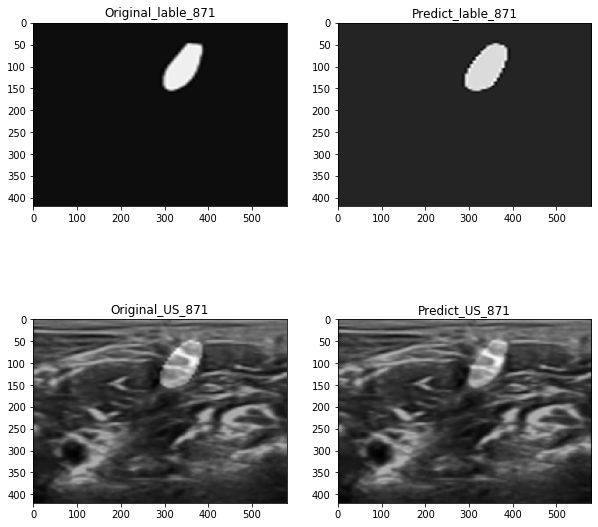

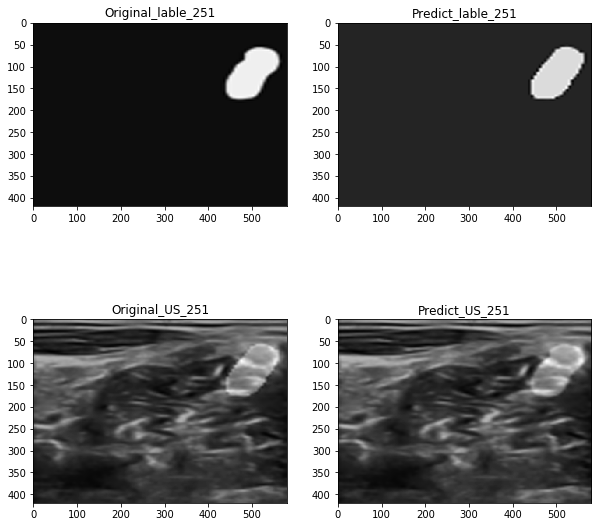

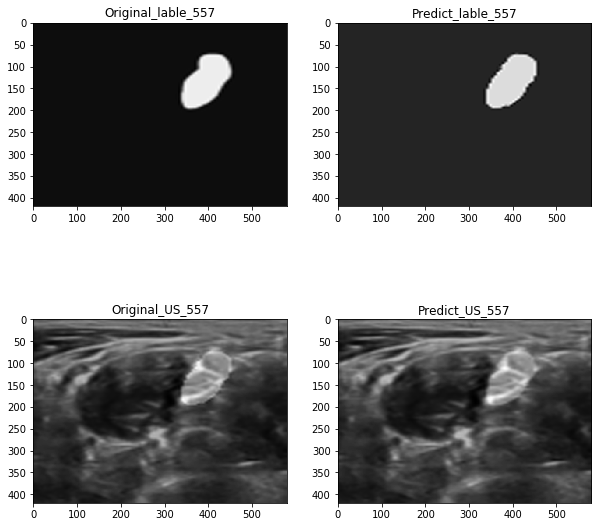

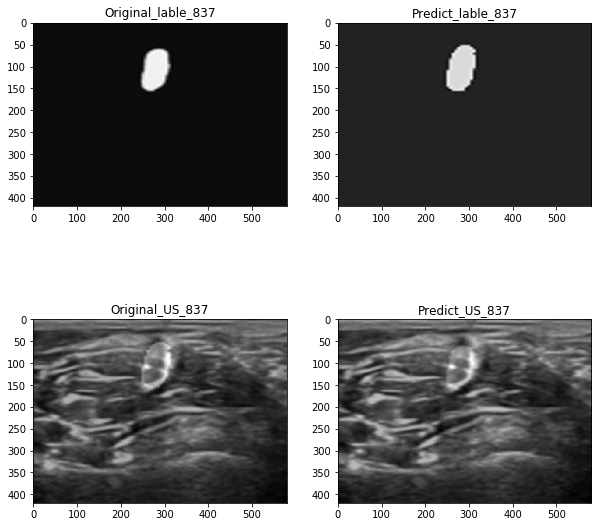

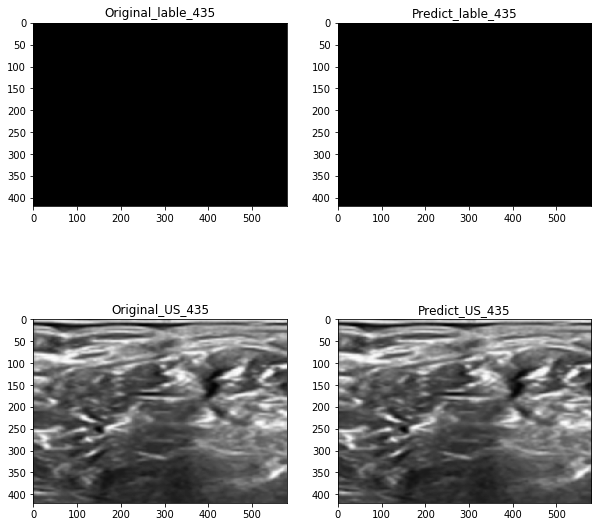

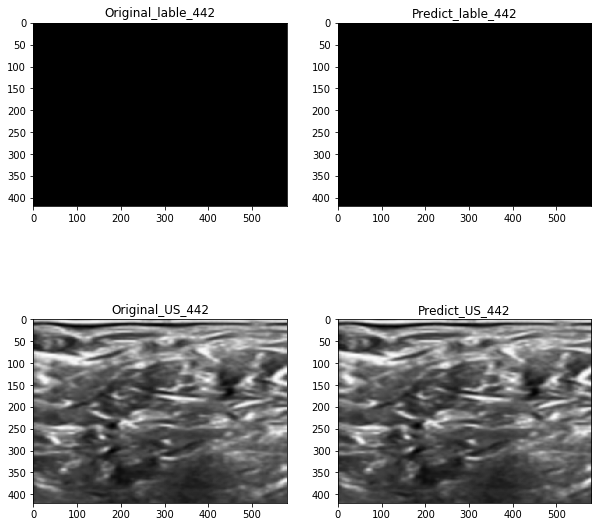

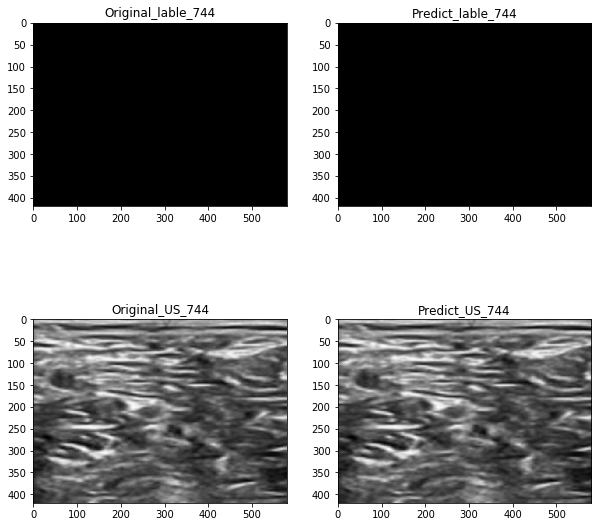

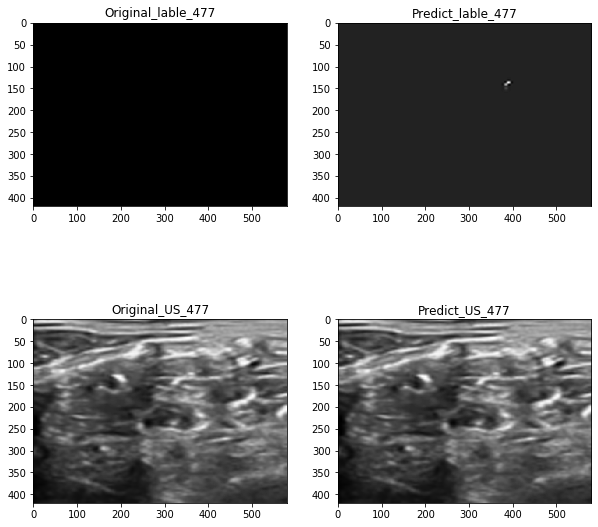

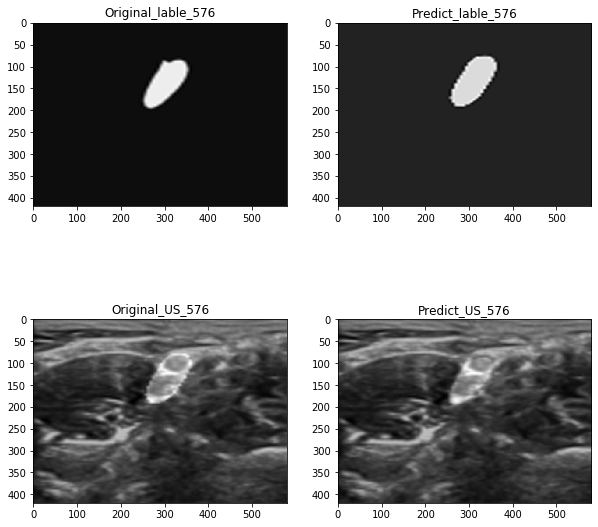

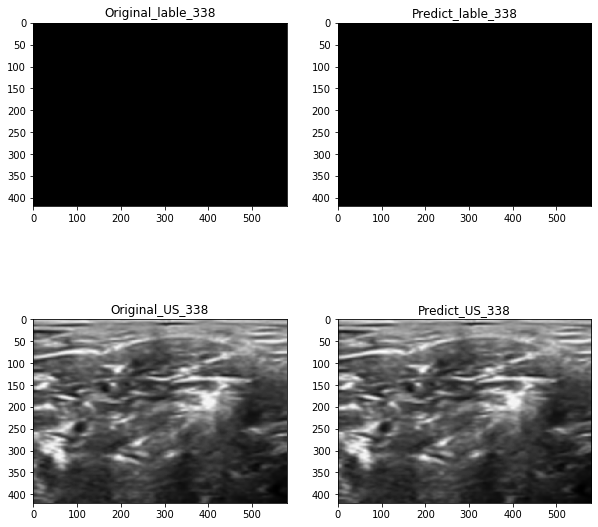

In [149]:
np.random.seed(0)
for num in np.random.choice(1127, 10, replace=False):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(cv2.resize(mask_test_u[num],(580,420),
                          interpolation=cv2.INTER_CUBIC), cmap='gray')
    plt.title('Original_lable_'+str(num))

    plt.subplot(2,2,2)
    plt.imshow( cv2.resize(mask_r[num],(580,420),
                           interpolation=cv2.INTER_CUBIC), cmap='gray')
    plt.title('Predict_lable_'+str(num))

    plt.subplot(2,2,3)
    plt.imshow(cv2.resize(img_test_o[num],(580,420),
                          interpolation=cv2.INTER_CUBIC), cmap='gray')
    plt.title('Original_US_'+str(num))

    plt.subplot(2,2,4)
    plt.imshow(cv2.resize(img_predict_o[num],(580,420),
                          interpolation=cv2.INTER_CUBIC), cmap='gray')
    plt.title('Predict_US_'+str(num))
    plt.savefig(path+'/Result'+str(num)+'.png')
    plt.show()


Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 17s - loss: 6.4675 - dice_coef: 0.1419 - recall: 0.5982 - precision: 0.1233 - mean_iou: 0.6397 - val_loss: 4.7840 - val_dice_coef: 0.2942 - val_recall: 0.5629 - val_precision: 0.2083 - val_mean_iou: 0.9659
Epoch 2/50
 - 13s - loss: 3.8505 - dice_coef: 0.4158 - recall: 0.4840 - precision: 0.4062 - mean_iou: 0.9811 - val_loss: 3.2228 - val_dice_coef: 0.3925 - val_recall: 0.3716 - val_precision: 0.4997 - val_mean_iou: 0.9862
Epoch 3/50
 - 13s - loss: 2.6798 - dice_coef: 0.5184 - recall: 0.5538 - precision: 0.5119 - mean_iou: 0.9847 - val_loss: 2.3881 - val_dice_coef: 0.4605 - val_recall: 0.5692 - val_precision: 0.4110 - val_mean_iou: 0.9824
Epoch 4/50
 - 13s - loss: 2.0455 - dice_coef: 0.5676 - recall: 0.6016 - precision: 0.5642 - mean_iou: 0.9858 - val_loss: 1.9271 - val_dice_coef: 0.4844 - val_recall: 0.4939 - val_precision: 0.5259 - val_mean_iou: 0.9861
Epoch 5/50
 - 13s - loss: 1.6861 - dice_coef: 0.5860 - recall: 

Epoch 38/50
 - 13s - loss: 0.4170 - dice_coef: 0.8040 - recall: 0.8013 - precision: 0.8292 - mean_iou: 0.9908 - val_loss: 0.7066 - val_dice_coef: 0.5170 - val_recall: 0.5173 - val_precision: 0.5485 - val_mean_iou: 0.9865
Epoch 39/50
 - 13s - loss: 0.4083 - dice_coef: 0.8077 - recall: 0.8014 - precision: 0.8361 - mean_iou: 0.9909 - val_loss: 0.7012 - val_dice_coef: 0.5155 - val_recall: 0.5130 - val_precision: 0.5482 - val_mean_iou: 0.9865
Epoch 40/50
 - 13s - loss: 0.3992 - dice_coef: 0.8119 - recall: 0.8069 - precision: 0.8404 - mean_iou: 0.9910 - val_loss: 0.6933 - val_dice_coef: 0.5192 - val_recall: 0.5357 - val_precision: 0.5327 - val_mean_iou: 0.9861
Epoch 41/50
 - 13s - loss: 0.3939 - dice_coef: 0.8123 - recall: 0.8092 - precision: 0.8386 - mean_iou: 0.9910 - val_loss: 0.6983 - val_dice_coef: 0.5101 - val_recall: 0.4982 - val_precision: 0.5591 - val_mean_iou: 0.9867
Epoch 42/50
 - 13s - loss: 0.3891 - dice_coef: 0.8123 - recall: 0.8094 - precision: 0.8394 - mean_iou: 0.9909 - val_

Epoch 13/50
 - 13s - loss: 0.2895 - dice_coef: 0.8477 - recall: 0.8403 - precision: 0.8876 - mean_iou: 0.9917 - val_loss: 0.3043 - val_dice_coef: 0.8343 - val_recall: 0.8502 - val_precision: 0.8490 - val_mean_iou: 0.9917
Epoch 14/50
 - 13s - loss: 0.2869 - dice_coef: 0.8498 - recall: 0.8427 - precision: 0.8905 - mean_iou: 0.9917 - val_loss: 0.3074 - val_dice_coef: 0.8309 - val_recall: 0.8376 - val_precision: 0.8561 - val_mean_iou: 0.9918
Epoch 15/50
 - 13s - loss: 0.2853 - dice_coef: 0.8509 - recall: 0.8434 - precision: 0.8920 - mean_iou: 0.9917 - val_loss: 0.3075 - val_dice_coef: 0.8302 - val_recall: 0.8477 - val_precision: 0.8437 - val_mean_iou: 0.9917
Epoch 16/50
 - 13s - loss: 0.2821 - dice_coef: 0.8536 - recall: 0.8474 - precision: 0.8923 - mean_iou: 0.9918 - val_loss: 0.3083 - val_dice_coef: 0.8290 - val_recall: 0.8450 - val_precision: 0.8441 - val_mean_iou: 0.9916

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 00016: early stopping
[0.3082

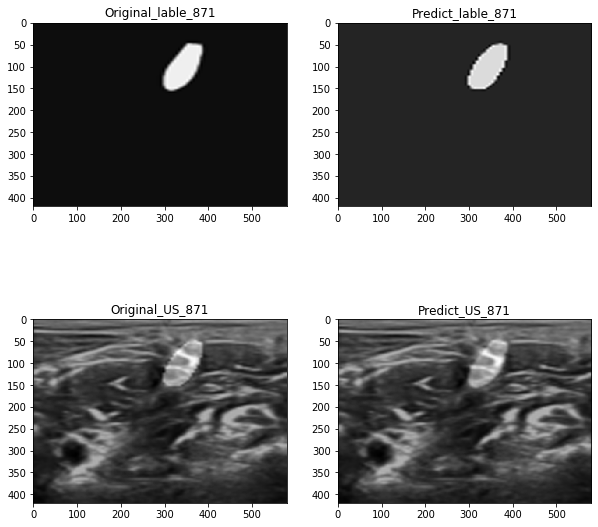

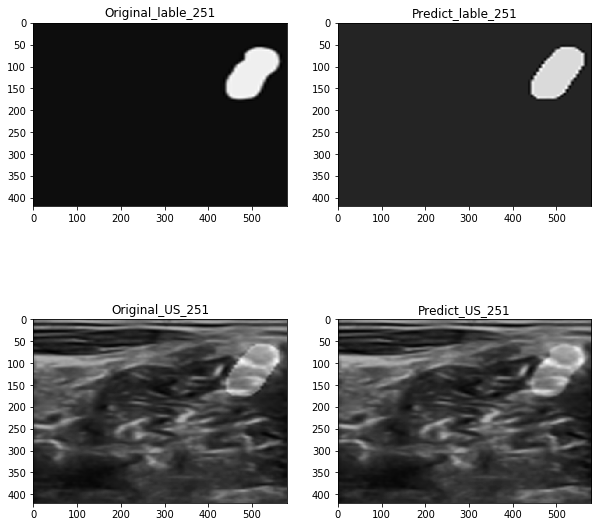

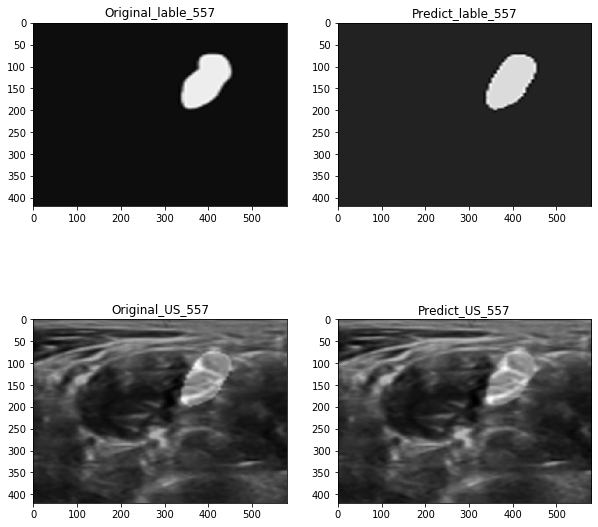

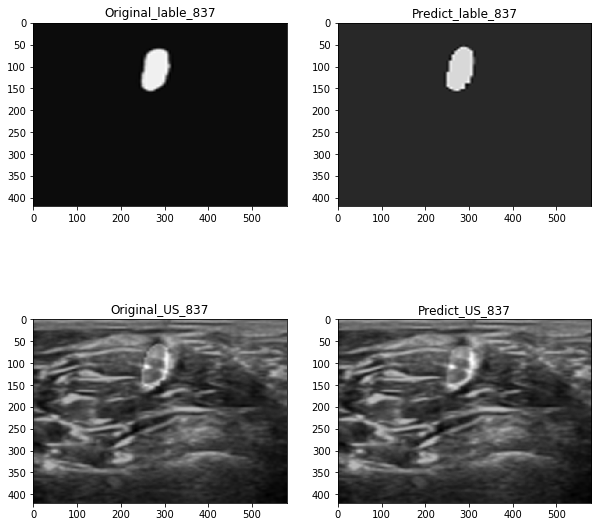

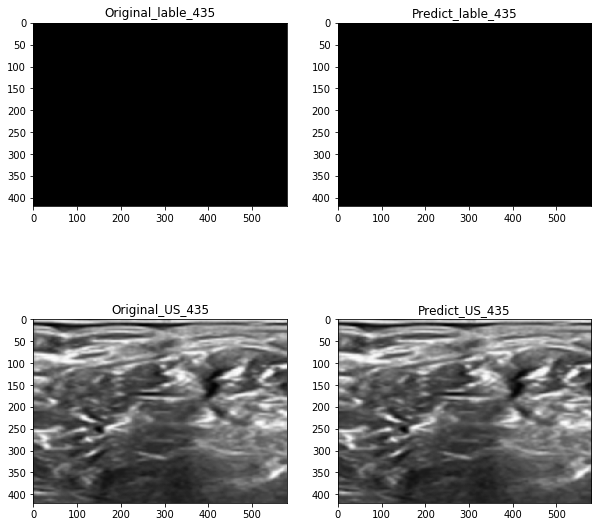

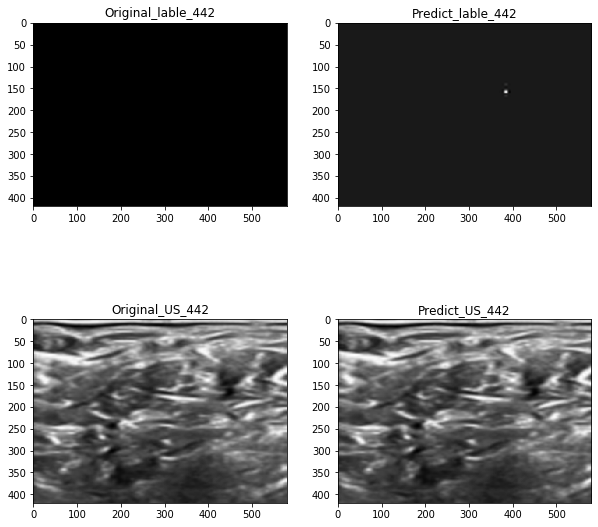

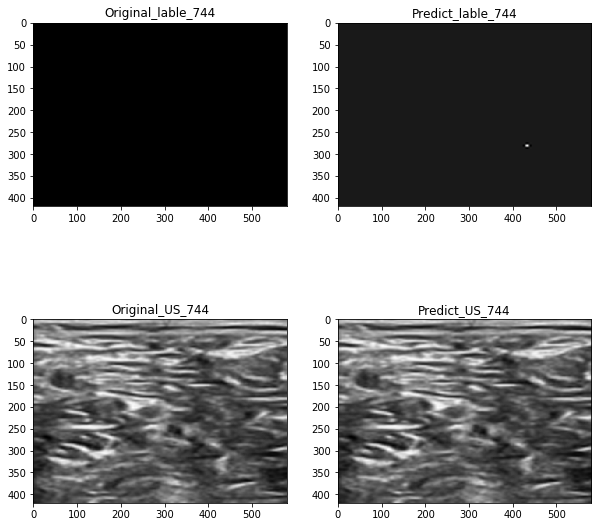

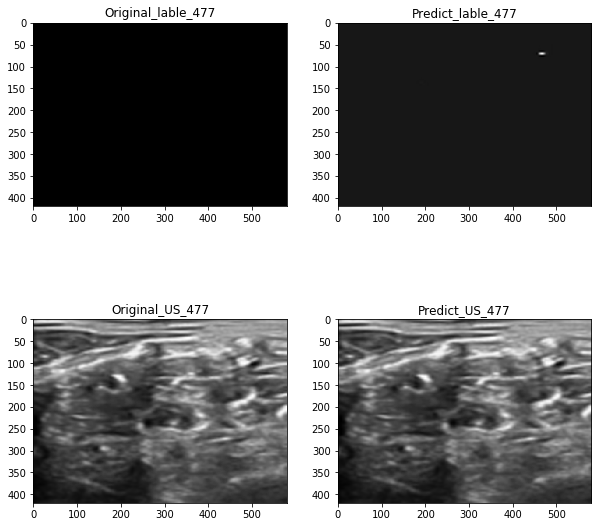

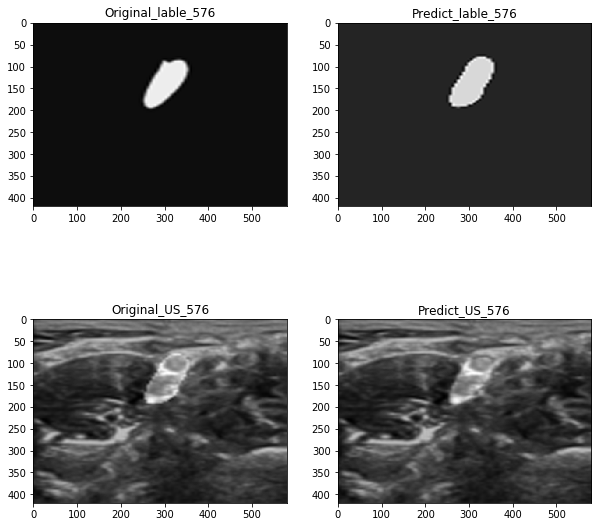

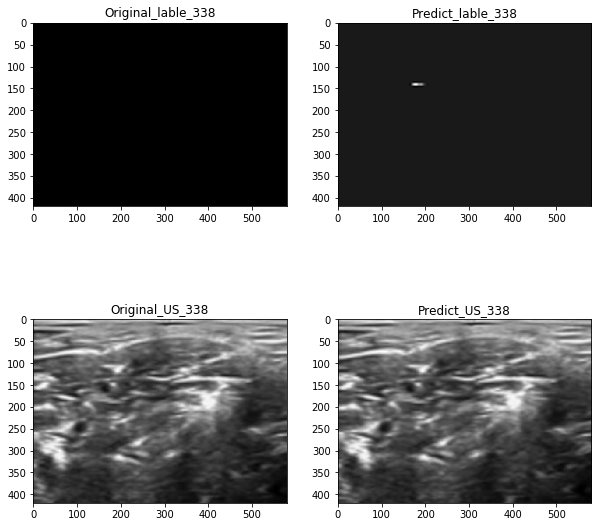


Fold  0
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 17s - loss: 6.4893 - dice_coef: 0.1222 - recall: 0.6032 - precision: 0.1023 - mean_iou: 0.6300 - val_loss: 4.8588 - val_dice_coef: 0.2614 - val_recall: 0.3037 - val_precision: 0.2558 - val_mean_iou: 0.9791
Epoch 2/50
 - 13s - loss: 4.0914 - dice_coef: 0.3523 - recall: 0.4491 - precision: 0.3193 - mean_iou: 0.9779 - val_loss: 3.5298 - val_dice_coef: 0.3936 - val_recall: 0.5388 - val_precision: 0.3251 - val_mean_iou: 0.9786
Epoch 3/50
 - 13s - loss: 3.1032 - dice_coef: 0.4772 - recall: 0.5296 - precision: 0.4568 - mean_iou: 0.9833 - val_loss: 2.8721 - val_dice_coef: 0.4091 - val_recall: 0.3998 - val_precision: 0.4732 - val_mean_iou: 0.9858
Epoch 4/50
 - 13s - loss: 2.5639 - dice_coef: 0.5094 - recall: 0.5574 - precision: 0.5028 - mean_iou: 0.9841 - val_loss: 2.4442 - val_dice_coef: 0.4409 - val_recall: 0.6128 - val_precision: 0.3567 - val_mean_iou: 0.9793
Epoch 5/50
 - 13s - loss: 2.1978 - dice_coef: 0.5454 - recall: 

Epoch 38/50
 - 13s - loss: 0.6173 - dice_coef: 0.7260 - recall: 0.7325 - precision: 0.7417 - mean_iou: 0.9892 - val_loss: 0.8300 - val_dice_coef: 0.5101 - val_recall: 0.5111 - val_precision: 0.5472 - val_mean_iou: 0.9865
Epoch 39/50
 - 13s - loss: 0.6118 - dice_coef: 0.7246 - recall: 0.7317 - precision: 0.7353 - mean_iou: 0.9892 - val_loss: 0.7977 - val_dice_coef: 0.5354 - val_recall: 0.5915 - val_precision: 0.5106 - val_mean_iou: 0.9854
Epoch 40/50
 - 13s - loss: 0.5995 - dice_coef: 0.7298 - recall: 0.7372 - precision: 0.7431 - mean_iou: 0.9893 - val_loss: 0.8006 - val_dice_coef: 0.5239 - val_recall: 0.5355 - val_precision: 0.5420 - val_mean_iou: 0.9864
Epoch 41/50
 - 13s - loss: 0.5914 - dice_coef: 0.7306 - recall: 0.7358 - precision: 0.7462 - mean_iou: 0.9894 - val_loss: 0.7791 - val_dice_coef: 0.5399 - val_recall: 0.5671 - val_precision: 0.5372 - val_mean_iou: 0.9862
Epoch 42/50
 - 13s - loss: 0.5778 - dice_coef: 0.7375 - recall: 0.7444 - precision: 0.7490 - mean_iou: 0.9894 - val_

Epoch 13/50
 - 13s - loss: 0.4531 - dice_coef: 0.7706 - recall: 0.7670 - precision: 0.7943 - mean_iou: 0.9901 - val_loss: 0.4589 - val_dice_coef: 0.7661 - val_recall: 0.7926 - val_precision: 0.7937 - val_mean_iou: 0.9906
Epoch 14/50
 - 13s - loss: 0.4487 - dice_coef: 0.7744 - recall: 0.7731 - precision: 0.7959 - mean_iou: 0.9901 - val_loss: 0.4600 - val_dice_coef: 0.7644 - val_recall: 0.7979 - val_precision: 0.7851 - val_mean_iou: 0.9905
Epoch 15/50
 - 13s - loss: 0.4485 - dice_coef: 0.7739 - recall: 0.7698 - precision: 0.7973 - mean_iou: 0.9902 - val_loss: 0.4581 - val_dice_coef: 0.7657 - val_recall: 0.7921 - val_precision: 0.7941 - val_mean_iou: 0.9906
Epoch 16/50
 - 13s - loss: 0.4474 - dice_coef: 0.7742 - recall: 0.7681 - precision: 0.8008 - mean_iou: 0.9902 - val_loss: 0.4610 - val_dice_coef: 0.7620 - val_recall: 0.8064 - val_precision: 0.7719 - val_mean_iou: 0.9903
Epoch 17/50
 - 13s - loss: 0.4451 - dice_coef: 0.7759 - recall: 0.7720 - precision: 0.7986 - mean_iou: 0.9902 - val_

[0.4581738667299817, 0.7466623783111572, 0.7631210684776306, 0.7853821516036987, 0.9903923869132996]

Fold  3
Train on 4508 samples, validate on 1127 samples
Epoch 1/50
 - 13s - loss: 0.4139 - dice_coef: 0.7885 - recall: 0.7861 - precision: 0.8098 - mean_iou: 0.9905 - val_loss: 0.4124 - val_dice_coef: 0.7921 - val_recall: 0.8062 - val_precision: 0.8334 - val_mean_iou: 0.9907
Epoch 2/50
 - 13s - loss: 0.4108 - dice_coef: 0.7910 - recall: 0.7858 - precision: 0.8168 - mean_iou: 0.9906 - val_loss: 0.4123 - val_dice_coef: 0.7919 - val_recall: 0.7892 - val_precision: 0.8525 - val_mean_iou: 0.9909
Epoch 3/50
 - 13s - loss: 0.4100 - dice_coef: 0.7914 - recall: 0.7896 - precision: 0.8148 - mean_iou: 0.9906 - val_loss: 0.4193 - val_dice_coef: 0.7843 - val_recall: 0.8118 - val_precision: 0.8105 - val_mean_iou: 0.9903
Epoch 4/50
 - 13s - loss: 0.4082 - dice_coef: 0.7926 - recall: 0.7886 - precision: 0.8169 - mean_iou: 0.9907 - val_loss: 0.4193 - val_dice_coef: 0.7837 - val_recall: 0.8079 - val_pre

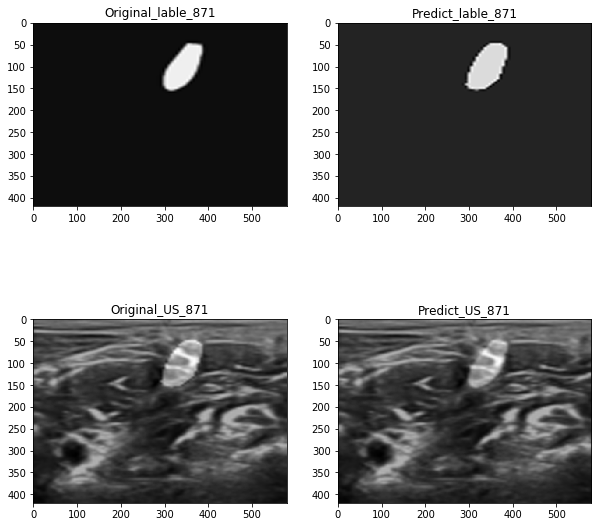

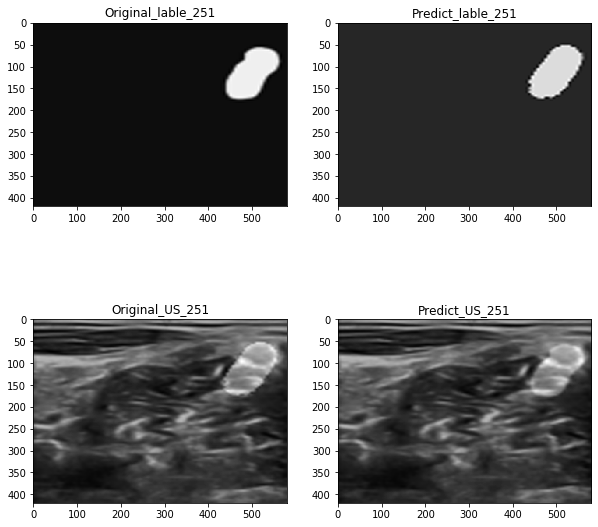

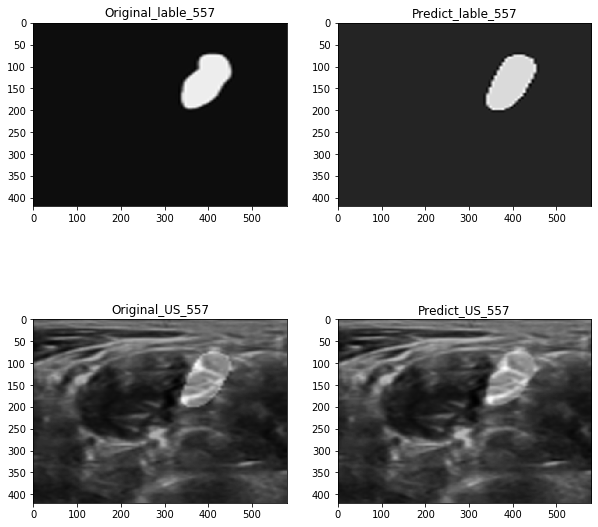

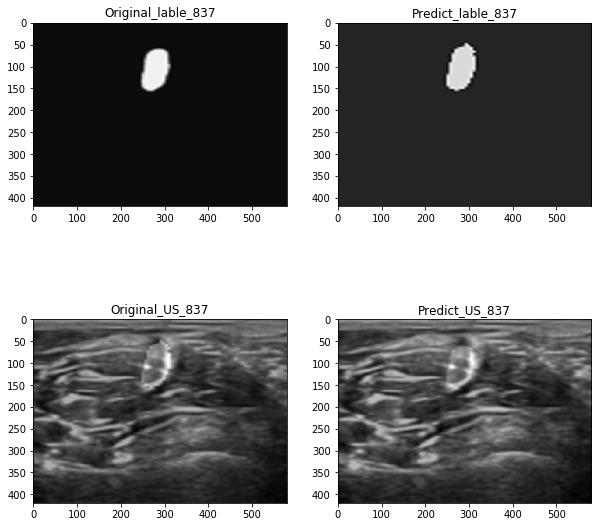

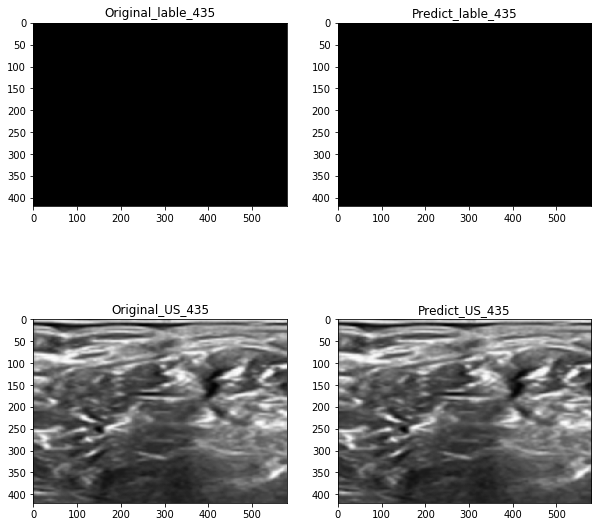

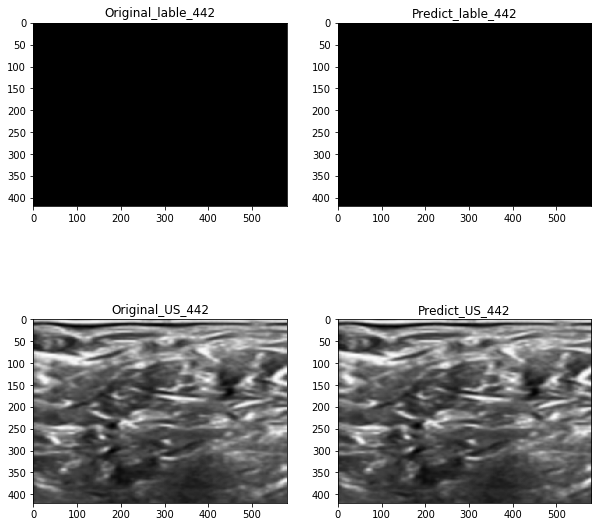

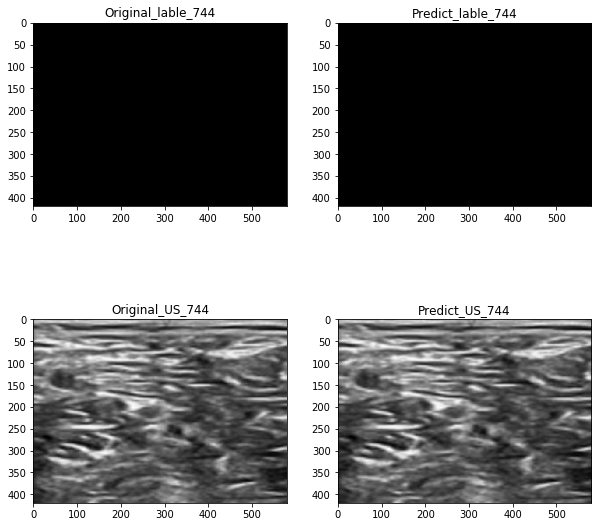

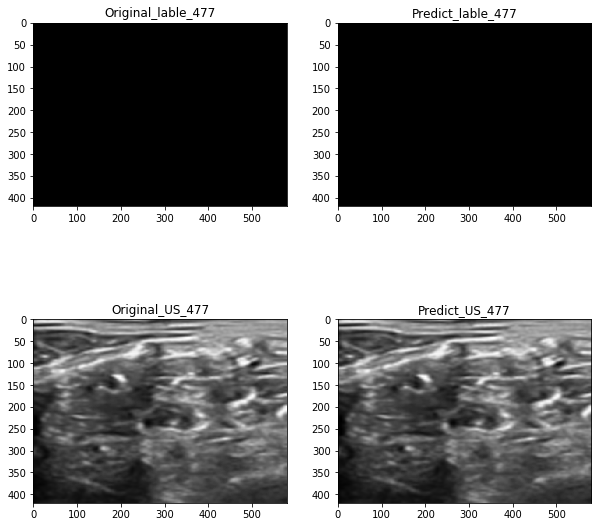

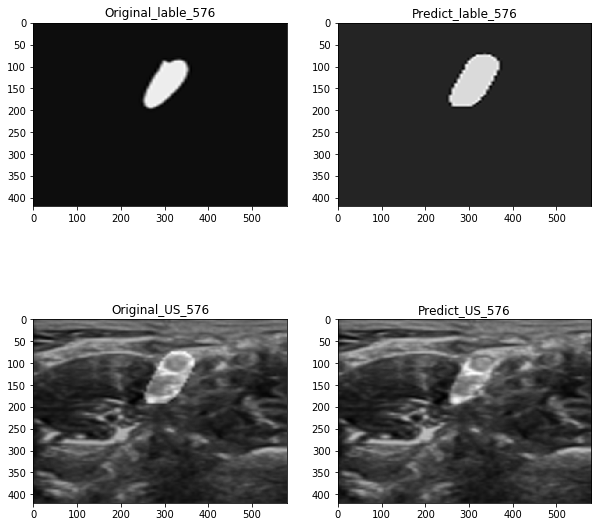

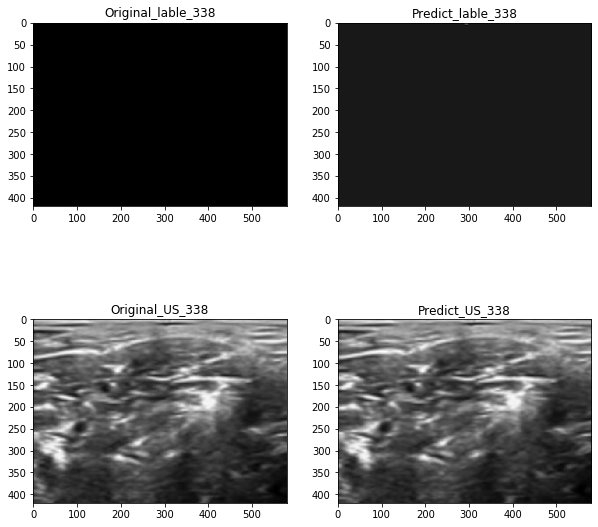


Fold  0


KeyboardInterrupt: 

In [184]:
import h5py
for ind_fil in [20]:
    image_c = preprocess_img(image_t)
    for ind in ["/새 폴더 (5)", "/새 폴더 (6)", "/새 폴더 (7)"]:
        path = "./Result/U_Net_CAE/SRAD/"+str(ind_fil) +ind
        winodw_size = 0
        CAE_Unet = get_CAE_Unet()

        for j, (train_idx, val_idx) in enumerate(folds):
            now = time.localtime()
            s = "%02d-%02d-%02d_%02d;%02d" % (now.tm_year-2000,
                                          now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min)
            print('\nFold ', j)
            image_train_cv = image_c[train_idx]
            mask_train_cv = mask_c[train_idx]
            image_valid_cv = image_c[val_idx]
            mask_valid_cv = mask_c[val_idx]

            name_weights = path+"/final_model_fold_" + \
                str(j) + str(winodw_size) + "_weights.h5"
            callbackk = get_callbacks(name_weights=name_weights, patience_lr=10)

            history = CAE_Unet.fit(image_train_cv, mask_train_cv, epochs=50, verbose=2, shuffle=True, validation_data=(
            image_valid_cv, mask_valid_cv), batch_size=32, callbacks=callbackk)

            if history.history['dice_coef'][-1] < 0.05:
                break
            df = pd.DataFrame({"val_loss": history.history['val_loss'],
                           "val_dice_coef": history.history['val_dice_coef'],
                           "val_precision": history.history['val_precision'],
                           "val_recall": history.history['val_recall']})
            df = df*100
            df.to_csv(
                path+'/history_{:2.3}_{}.csv'.format(history.history['val_dice_coef'][-1], s))
            print(CAE_Unet.evaluate(image_valid_cv, mask_valid_cv, verbose=2))

        mask_predict = CAE_Unet.predict(image_valid_cv, verbose=2)

        mask_r = mask_predict.reshape(1127, 96, 96)
        mask_test_u = mask_valid_cv.reshape(1127, 96, 96)
        image_test_u = image_valid_cv.reshape(1127, 96, 96)

        img_test_o = (mask_r*2)+image_test_u
        img_predict_o = image_test_u+(mask_test_u*2)

        np.random.seed(0)
        for num in np.random.choice(1127, 10, replace=False):
            plt.figure(figsize=(10, 10))
            plt.subplot(2, 2, 1)
            plt.imshow(cv2.resize(mask_test_u[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Original_lable_'+str(num))

            plt.subplot(2, 2, 2)
            plt.imshow(cv2.resize(mask_r[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Predict_lable_'+str(num))

            plt.subplot(2, 2, 3)
            plt.imshow(cv2.resize(img_test_o[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Original_US_'+str(num))

            plt.subplot(2, 2, 4)
            plt.imshow(cv2.resize(img_predict_o[num], (580, 420),
                                  interpolation=cv2.INTER_CUBIC), cmap='gray')
            plt.title('Predict_US_'+str(num))
            plt.savefig(path+'/Result'+str(num)+'.png')
            plt.show()